# Graph Neural Networks
### Graph Neural Networks (GNNs) is a supervised learning algorithm designed to process data structured as graphs by aggregating information from neighboring nodes, making it ideal for tasks like detecting fraudulent transactions in financial networks. It excels in analyzing relationships between accounts and transactions (e.g., identifying suspicious patterns based on transaction connectivity) and can handle graph-based data, requiring iterative training to update node representations. The algorithm assumes that node features and their neighborhood relationships are informative, which enables effective pattern learning but may not hold for graphs with sparse or noisy connections. Its strength lies in its ability to capture complex relational patterns in networked data, but it can be computationally intensive, prone to overfitting without regularization, and sensitive to hyperparameter choices (e.g., number of layers, aggregation method)

### Use GNNs as an tool for fraud detection or network analysis systems.

| Aspect | Details |
| :- | :- |
| Use For           | Graph-based classification (e.g., fraud detection, social network analysis)<br>Can be extended to link prediction or graph generation |
| Key Assumptions   | - Node features and neighborhood relationships are informative<br>- Independent observations<br>- Sufficient graph density for learning |
| Advantages        | - Captures relational patterns in graphs<br>- Effective for networked data<br>- Flexible with various aggregation methods |
| Disadvantages     | - Computationally intensive during training<br>- Prone to overfitting without regularization<br>- Sensitive to hyperparameter tuning |
| Avoid When        | - Sparse or noisy graphs with limited connectivity<br>- Very small datasets with few nodes<br>- Real-time applications with low latency |
| Real-World Use Case | Fraud detection (e.g., identifying suspicious transactions in financial networks)<br>Social network analysis (e.g., predicting user connections) |

## Problem Description: 
### Detect fraudulent transactions in a financial network by analyzing relationships between accounts, transactions, and users. This is a graph-based classification problem where GNNs leverage the connectivity and structure of the transaction graph to identify anomalies.

Using dataset https://www.kaggle.com/datasets/ellipticco/elliptic-data-set

In [254]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import joblib
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [255]:
def setup_gpu():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    return device

In [256]:
device = setup_gpu()

Using device: cuda


In [257]:
project_dir = './16_gnn_graph_neural_network'

data_dir = project_dir + '/data/'

edges = pd.read_csv(os.path.join(data_dir, 'elliptic_txs_edgelist.csv'))
classes = pd.read_csv(os.path.join(data_dir, 'elliptic_txs_classes.csv'))
features = pd.read_csv(os.path.join(data_dir, 'elliptic_txs_features.csv'), header=None)

In [258]:
# preprocess data
features.columns = ['txId'] + [f'feature_{i}' for i in range(1, 167)]
data_merged = pd.merge(features, classes, on='txId', how='left')
data_merged['class'] = data_merged['class'].map({'unknown': 0, '1': 1, '2': 2})  # 0: unknown, 1: illicit, 2: licit

# create edge index
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

# prepare node features and labels
node_features = torch.tensor(data_merged.drop(columns=['txId', 'class']).values, dtype=torch.float)
node_labels = torch.tensor(data_merged['class'].values, dtype=torch.long)

# filter out unknown labels for supervised learning (use only illicit/licit)
mask = node_labels != 0
node_features = node_features[mask]
node_labels = node_labels[mask] - 1  # Map 1->0, 2->1 for binary classification
edge_index = edge_index[:, (edge_index[0] < mask.sum()) & (edge_index[1] < mask.sum())]  # Adjust edges
edge_index = edge_index[:, edge_index[0] < edge_index[1]]

In [259]:
# create graph data
data = Data(x=node_features, edge_index=edge_index, y=node_labels).to(device)
print("Graph data shape:", data.x.shape, "Edges:", data.edge_index.shape, "Labels:", data.y.shape)

Graph data shape: torch.Size([46564, 166]) Edges: torch.Size([2, 12]) Labels: torch.Size([46564])


In [260]:
# split data for training and testing
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_idx = np.random.choice(data.num_nodes, int(0.8 * data.num_nodes), replace=False)
train_mask[train_idx] = True
test_mask[~train_mask] = True
data.train_mask = train_mask
data.test_mask = test_mask

In [261]:
# define the gcn model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(in_channels=166, hidden_channels=16, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

In [262]:
train_losses = []
train_accuracies = []
test_accuracies = []

# train the model
for epoch in range(1500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # evaluate  and store history
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        train_pred = out[data.train_mask].max(dim=1)[1]
        test_pred = out[data.test_mask].max(dim=1)[1]
        train_y = data.y[data.train_mask]
        test_y = data.y[data.test_mask]
        train_acc = accuracy_score(train_y.cpu(), train_pred.cpu())
        test_acc = accuracy_score(test_y.cpu(), test_pred.cpu())
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    if train_acc >= 0.985:  # early stopping condition
        break

Epoch: 1, Loss: 4.5460, Train Acc: 0.2152, Test Acc: 0.2156
Epoch: 2, Loss: 2.6205, Train Acc: 0.5498, Test Acc: 0.5463
Epoch: 3, Loss: 1.4253, Train Acc: 0.7822, Test Acc: 0.7820
Epoch: 4, Loss: 0.8506, Train Acc: 0.8493, Test Acc: 0.8505
Epoch: 5, Loss: 0.6463, Train Acc: 0.8711, Test Acc: 0.8732
Epoch: 6, Loss: 0.5521, Train Acc: 0.8836, Test Acc: 0.8838
Epoch: 7, Loss: 0.5247, Train Acc: 0.8919, Test Acc: 0.8936
Epoch: 8, Loss: 0.5323, Train Acc: 0.8964, Test Acc: 0.8981
Epoch: 9, Loss: 0.5340, Train Acc: 0.8987, Test Acc: 0.8999
Epoch: 10, Loss: 0.5376, Train Acc: 0.9007, Test Acc: 0.9014
Epoch: 11, Loss: 0.5347, Train Acc: 0.9017, Test Acc: 0.9029
Epoch: 12, Loss: 0.5260, Train Acc: 0.9030, Test Acc: 0.9030
Epoch: 13, Loss: 0.5069, Train Acc: 0.9044, Test Acc: 0.9045
Epoch: 14, Loss: 0.4916, Train Acc: 0.9057, Test Acc: 0.9057
Epoch: 15, Loss: 0.4699, Train Acc: 0.9069, Test Acc: 0.9075
Epoch: 16, Loss: 0.4415, Train Acc: 0.9082, Test Acc: 0.9091
Epoch: 17, Loss: 0.4203, Train Ac

In [263]:
# predict and evaluate
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out[data.test_mask].max(dim=1)[1]
    y_test = data.y[data.test_mask]
    accuracy = accuracy_score(y_test.cpu(), y_pred.cpu())
    conf_matrix = confusion_matrix(y_test.cpu(), y_pred.cpu())
    class_report = classification_report(y_test.cpu(), y_pred.cpu(), output_dict=True, zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test.cpu(), y_pred.cpu(), target_names=['Licit', 'Illicit']))

Accuracy: 0.98
Confusion Matrix:
[[ 756  163]
 [  26 8368]]
Classification Report:
              precision    recall  f1-score   support

       Licit       0.97      0.82      0.89       919
     Illicit       0.98      1.00      0.99      8394

    accuracy                           0.98      9313
   macro avg       0.97      0.91      0.94      9313
weighted avg       0.98      0.98      0.98      9313



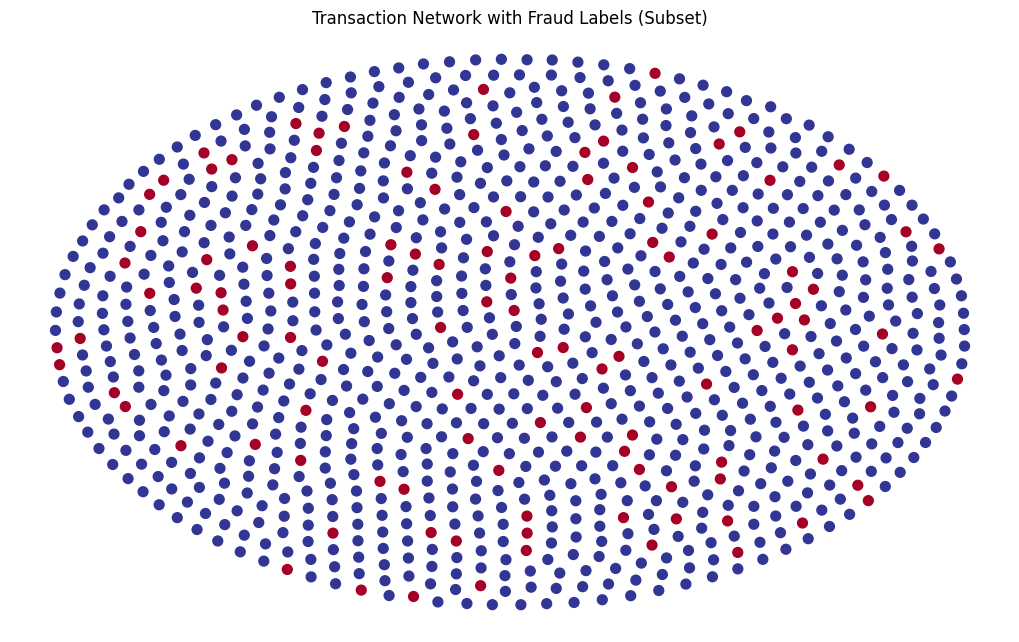

In [264]:
# visualize a subset of the transaction network with fraud labels

subset_size = 1000  # reduce for visualization
subset_nodes = torch.randperm(data.num_nodes)[:subset_size].cpu().numpy()
subset_nodes = subset_nodes[subset_nodes < data.y.shape[0]]
subset_nodes_set = set(subset_nodes.tolist())

# Filter edges to only those between nodes in the subset
edge_index_cpu = data.edge_index.cpu().numpy()
edges_subset = [
	(int(src), int(dst))
	for src, dst in edge_index_cpu.T
	if src in subset_nodes_set and dst in subset_nodes_set
]

G = nx.Graph()
G.add_nodes_from(subset_nodes)
G.add_edges_from(edges_subset)

# Node colors by label (ensure indices are valid)
# Move data.y to cpu and numpy for safe indexing
data_y_cpu = data.y.cpu().numpy()
node_colors = data_y_cpu[subset_nodes]

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))
nx.draw(
	G, pos,
	node_color=node_colors,
	cmap=plt.cm.RdYlBu,
	node_size=50,
	with_labels=False
)
plt.title('Transaction Network with Fraud Labels (Subset)')
plt.show()

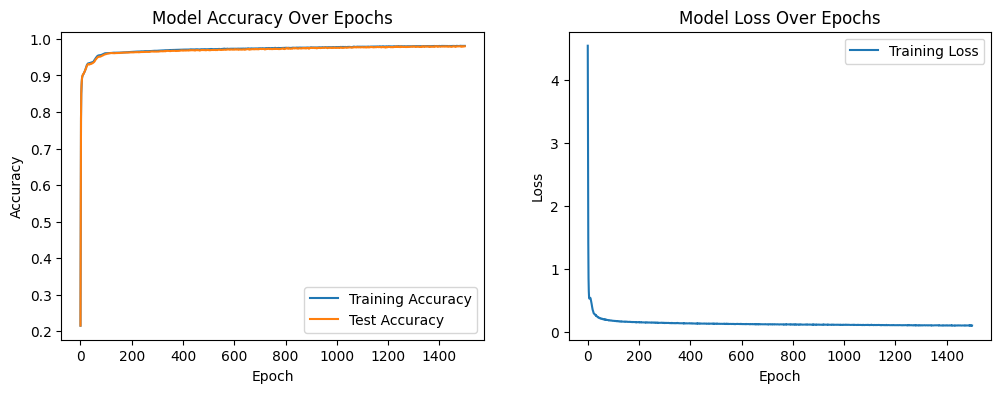

In [265]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

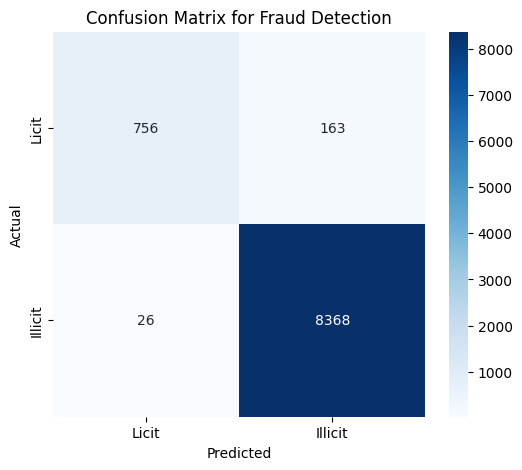

In [266]:
# visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Licit', 'Illicit'], yticklabels=['Licit', 'Illicit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Fraud Detection')
plt.show()

In [267]:
# save the model in a 'model' subdirectory
model_dir = project_dir + '/model'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'fraud_detection_gnn_model.h5')
torch.save(model.state_dict(), model_filename)
print(f'Model saved as {model_filename}')

Model saved as ./16_gnn_graph_neural_network/model/fraud_detection_gnn_model.h5


In [268]:
# load the trained GCN model with correct architecture
loaded_model = GCN(in_channels=166, hidden_channels=16, out_channels=2).to(device)
loaded_model.load_state_dict(torch.load(model_filename))
loaded_model.eval()

# create a new transaction feature vector (example: random, replace with real data as needed)
new_transaction_features = torch.randn(1, 166).to(device)

# for a single node, use an empty edge_index
empty_edge_index = torch.empty((2, 0), dtype=torch.long).to(device)

with torch.no_grad():
    new_node_out = loaded_model(new_transaction_features, empty_edge_index)
    new_pred = new_node_out.max(dim=1)[1]
print(f'Predicted label for new transaction: {"Illicit" if new_pred.item() == 1 else "Licit"}')

Predicted label for new transaction: Licit
